In [1]:
import os
import re
import glob
from datetime import datetime
import sys
import itertools
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
sys.path.append("..") # Adds higher directory to python modules path for importing from src dir

from src.algorithms import SimpleLSTM, MLPClassifier, SVC, Heuristic
from src.datasets import NyseStocksDataset
from src.evaluation import Evaluator
from src.utils import print_metrics_as_md, pandas_df_to_markdown_table
# from src.pipeline import run_pipeline, prepare_data, evaluate_results
# from src.experiments import get_metrics

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## 1. 15 runs

- SimpleLSTM with seeds from 42 to 56
- On OC-3C and OC-3C+
- 90k train, 9k test
- 512 batch size
- 150 epochs

| -  |   datasets    predictors     |     OC-3C    SLSTM_42   |     OC-3C    SLSTM_43   |     OC-3C    SLSTM_44   |     OC-3C    SLSTM_45   |     OC-3C    SLSTM_46   |     OC-3C    SLSTM_47   |     OC-3C    SLSTM_48   |     OC-3C    SLSTM_49   |     OC-3C    SLSTM_50   |     OC-3C    SLSTM_51   |     OC-3C    SLSTM_52   |     OC-3C    SLSTM_53   |     OC-3C    SLSTM_54   |     OC-3C    SLSTM_55   |     OC-3C    SLSTM_56   |     OC-3C+    SLSTM_42   |     OC-3C+    SLSTM_43   |     OC-3C+    SLSTM_44   |     OC-3C+    SLSTM_45   |     OC-3C+    SLSTM_46   |     OC-3C+    SLSTM_47   |     OC-3C+    SLSTM_48   |     OC-3C+    SLSTM_49   |     OC-3C+    SLSTM_50   |     OC-3C+    SLSTM_51   |     OC-3C+    SLSTM_52   |     OC-3C+    SLSTM_53   |     OC-3C+    SLSTM_54   |     OC-3C+    SLSTM_55   |     OC-3C+    SLSTM_56   |
|---:|:-----------------------------|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|
|  0 | prec                         |                 0.36441 |                 0.35397 |                 0.38462 |                 0.36813 |                 0.37811 |                 0.37419 |                 0.38523 |                 0.34052 |                 0.3722  |                 0.39108 |                 0.35703 |                 0.38181 |                 0.36864 |                 0.34628 |                 0.37142 |                  0.22822 |                  0.32555 |                  0.36945 |                  0.36879 |                  0.31527 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |
|  1 | rec                          |                 0.37278 |                 0.35878 |                 0.381   |                 0.37911 |                 0.38744 |                 0.38322 |                 0.37844 |                 0.36167 |                 0.37011 |                 0.38311 |                 0.37022 |                 0.37833 |                 0.37867 |                 0.36544 |                 0.37789 |                  0.34022 |                  0.33311 |                  0.37656 |                  0.37322 |                  0.34011 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |
|  2 | f1                           |                 0.29667 |                 0.24276 |                 0.29404 |                 0.31864 |                 0.3297  |                 0.31781 |                 0.2985  |                 0.26826 |                 0.2745  |                 0.29808 |                 0.28126 |                 0.29798 |                 0.31248 |                 0.28542 |                 0.30624 |                  0.19255 |                  0.2956  |                  0.29925 |                  0.28082 |                  0.19564 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |
|  3 | acc                          |                 0.37278 |                 0.35878 |                 0.381   |                 0.37911 |                 0.38744 |                 0.38322 |                 0.37844 |                 0.36167 |                 0.37011 |                 0.38311 |                 0.37022 |                 0.37833 |                 0.37867 |                 0.36544 |                 0.37789 |                  0.34022 |                  0.33311 |                  0.37656 |                  0.37322 |                  0.34011 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |
|  4 | mcc                          |                 0.07882 |                 0.06828 |                 0.10221 |                 0.08302 |                 0.09732 |                 0.09366 |                 0.094   |                 0.06191 |                 0.08404 |                 0.10601 |                 0.07855 |                 0.09329 |                 0.08554 |                 0.06459 |                 0.08684 |                  0.03069 |                 -0.00037 |                  0.08678 |                  0.08774 |                  0.02772 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |


**Outcome**: Execution became very slow after a few iterations. Had to stop after 20 out of 30. Nevertheless OC-3C+ appears to be worse. The histories show that a the accuracy is not changing at all (especially on OC-3+) -> lower batch size / higher learning rate?

**Winner**: OC-3C

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/prices-15-runs.csv")

## 2. 5 runs (bs=64)

- SimpleLSTM with seeds from 42 to 46
- On OC-3C and OC-3C+
- 60k train, 6k test
- 64 batch size
- 150 epochs

| -  |   datasets    predictors     |     OC-3C    SLSTM_b64_42   |     OC-3C    SLSTM_b64_43   |     OC-3C    SLSTM_b64_44   |     OC-3C    SLSTM_b64_45   |     OC-3C    SLSTM_b64_46   |     OC-3C+    SLSTM_b64_42   |     OC-3C+    SLSTM_b64_43   |     OC-3C+    SLSTM_b64_44   |     OC-3C+    SLSTM_b64_45   |     OC-3C+    SLSTM_b64_46   |
|---:|:-----------------------------|----------------------------:|----------------------------:|----------------------------:|----------------------------:|----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|
|  0 | prec                         |                     0.11111 |                     0.32211 |                     0.22711 |                     0.31561 |                     0.23353 |                      0.11111 |                      0.11111 |                      0.36631 |                            0 |                            0 |
|  1 | rec                          |                     0.33333 |                     0.34283 |                     0.33767 |                     0.3465  |                     0.33883 |                      0.33333 |                      0.33333 |                      0.37983 |                            0 |                            0 |
|  2 | f1                           |                     0.16667 |                     0.30668 |                     0.1786  |                     0.21627 |                     0.18374 |                      0.16667 |                      0.16667 |                      0.31404 |                            0 |                            0 |
|  3 | acc                          |                     0.33333 |                     0.34283 |                     0.33767 |                     0.3465  |                     0.33883 |                      0.33333 |                      0.33333 |                      0.37983 |                            0 |                            0 |
|  4 | mcc                          |                     0       |                     0.01561 |                     0.02991 |                     0.04257 |                     0.03177 |                      0       |                      0       |                      0.08696 |    

**Outcome**: Same problems. Even worse results for OC-3C

**Winner**: -

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/prices-5-runs-bs64.csv")

## 3. 5 runs (bs=16)

- SimpleLSTM with seeds from 42 to 46
- On OC-3C and OC-3C+
- 45k train, 4.5k test
- 16 batch size
- 100 epochs

| -  |   datasets    predictors     |     OC-3C    SLSTM_b16_42   |     OC-3C    SLSTM_b16_43   |     OC-3C    SLSTM_b16_44   |     OC-3C    SLSTM_b16_45   |     OC-3C    SLSTM_b16_46   |     OC-3C+    SLSTM_b16_42   |     OC-3C+    SLSTM_b16_43   |     OC-3C+    SLSTM_b16_44   |     OC-3C+    SLSTM_b16_45   |     OC-3C+    SLSTM_b16_46   |
|---:|:-----------------------------|----------------------------:|----------------------------:|----------------------------:|----------------------------:|----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|
|  0 | prec                         |                     0.25112 |                     0.11111 |                     0.11111 |                     0.11111 |                     0.11111 |                      0.11111 |                      0.11111 |                      0.2391  |                      0.11111 |                      0.11111 |
|  1 | rec                          |                     0.34022 |                     0.33333 |                     0.33333 |                     0.33333 |                     0.33333 |                      0.33333 |                      0.33333 |                      0.33867 |                      0.33333 |                      0.33333 |
|  2 | f1                           |                     0.18983 |                     0.16667 |                     0.16667 |                     0.16667 |                     0.16667 |                      0.16667 |                      0.16667 |                      0.1848  |                      0.16667 |                      0.16667 |
|  3 | acc                          |                     0.34022 |                     0.33333 |                     0.33333 |                     0.33333 |                     0.33333 |                      0.33333 |                      0.33333 |                      0.33867 |                      0.33333 |                      0.33333 |
|  4 | mcc                          |                     0.03562 |                     0       |                     0       |                     0       |                     0       |                      0       |                      0       |                      0.03018 |                      0       |                      0       |


**Outcome**: Same problems. Even worse results for OC-3C

**Winner**: -

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/prices-5-runs-bs16.csv")

Failed settings:
- n_units=[128, 128], lstm_dropout=0.4, lr=0.001, bs=16, epoch=20, 45k
- n_units=[256, 256], bs=64, epoch=10, 150k

# 4. 2 runs on new test data

- SimpleLSTM with seeds from 42 to 43, Heuristics, MLP, SVC
- On OCM-3C
- 240k train, 48k test (not balanced)
- 64 batch size
- 100 epochs
- 64 & 64 units
- 0.001 learning rate

|  -   |     OCM-3C    SLSTM_s42   |     OCM-3C    SLSTM_s43   |     OCM-3C    Heuristic_all   |     OCM-3C    Heuristic_l1   |     OCM-3C    Heuristic_l3   |     OCM-3C    MLP   |     OCM-3C    SVC   |
|:-----|-------------------------:|-------------------------:|-----------------------------:|----------------------------:|----------------------------:|--------------------:|--------------------:|
| prec |                  0.50297 |                  0.50447 |                      0.48738 |                     0.49216 |                     0.47567 |             0.50176 |             0.46663 |
| rec  |                  0.56846 |                  0.56006 |                      0.61102 |                     0.49181 |                     0.57175 |             0.4454  |             0.62292 |
| f1   |                  0.52308 |                  0.52249 |                      0.49012 |                     0.49198 |                     0.50026 |             0.4658  |             0.47941 |
| acc  |                  0.56846 |                  0.56006 |                      0.61102 |                     0.49181 |                     0.57175 |             0.4454  |             0.62292 |
| mcc  |                  0.08959 |                  0.09124 |                      0.03097 |                     0.06258 |                     0.03274 |             0.06744 |             0.00323 |

- 300k train, 60k test (not balanced)

| -   |     OCM-3C    SLSTM_s42   |     OCM-3C    SLSTM_s43   |     OCM-3C    SLSTM_s44   |     OCM-3C    SLSTM_s45   |     OCM-3C    SLSTM_s46   |
|----:|--------------------------:|--------------------------:|--------------------------:|--------------------------:|--------------------------:|
| prec |                   0.50293 |                   0.4975  |                   0.49854 |                   0.50154 |                   0.5016  |
| rec  |                   0.57063 |                   0.56078 |                   0.55942 |                   0.5645  |                   0.55707 |
| f1   |                   0.52398 |                   0.51929 |                   0.51967 |                   0.52249 |                   0.5215  |
| acc  |                   0.57063 |                   0.56078 |                   0.55942 |                   0.5645  |                   0.55707 |
| mcc  |                   0.08826 |                   0.07947 |                   0.07988 |                   0.08581 |                   0.08591 |

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/all-baselines-slstm.csv")

| -  |   datasets    predictors     |     OCM-3C    SLSTM_b128_128_128   |     OCM-3C    SLSTM_b64_128_128   |     OCM-3C    SLSTM_b64_128_64   |     OCM-3C    SLSTM_b64_32_32   |     OCM-3C    SLSTM_b64_64_32   |     OCM-3C    SLSTM_b32_32_32   |     OCM-3C    SLSTM_b16_16_16   |     OCM-3C    SLSTM_b8_8_8   |     OCM-3C    SLSTM_b8_8_8(2)   |
|---:|:-----------------------------|-----------------------------------:|----------------------------------:|---------------------------------:|--------------------------------:|--------------------------------:|--------------------------------:|--------------------------------:|-----------------------------:|--------------------------------:|
|  0 | prec                         |                            0.4966  |                           0.49447 |                          0.49815 |                         0.50036 |                         0.5015  |                         0.50269 |                         0.50714 |                      0.50504 |                      0.51500 |
|  1 | rec                          |                            0.5485  |                           0.5448  |                          0.55992 |                         0.57728 |                         0.57017 |                         0.57622 |                         0.57520 |                      0.58367 |                      0.57900 |
|  2 | f1                           |                            0.51593 |                           0.51343 |                          0.5192  |                         0.52202 |                         0.52266 |                         0.52456 |                         0.52718 |                      0.52674 |                      0.53462 |
|  3 | acc                          |                            0.5485  |                           0.5448  |                          0.55992 |                         0.57728 |                         0.57017 |                         0.57622 |                         0.57520 |                      0.58367 |                      0.57900 |
|  4 | mcc                          |                            0.07971 |                           0.0756  |                          0.08366 |                         0.08933 |                         0.09105 |                         0.09185 |                         0.09787 |                      0.09470 |                      0.11367 |

#### Heuristics

| -  |   datasets    predictors     |     OCMvOC-3C    Heuristic_a-1   |     OCMvOC-3C    Heuristic_a0   |     OCMvOC-3C    Heuristic_a1   |     OCMvOC-3C    Heuristic_l1   |     OCMvOC-3C    Heuristic_rand   |     OCMvOC-3C    Heuristic_v_l1   |
|---:|:-----------------------------|---------------------------------:|--------------------------------:|--------------------------------:|--------------------------------:|----------------------------------:|----------------------------------:|
|  0 | prec                         |                          0.02781 |                         0.39088 |                         0.04328 |                         0.49883 |                           0.46474 |                           0.48106 |
|  1 | rec                          |                          0.16675 |                         0.6252  |                         0.20805 |                         0.49527 |                           0.33573 |                           0.53682 |
|  2 | f1                           |                          0.04766 |                         0.48102 |                         0.07166 |                         0.49701 |                           0.36472 |                           0.5019  |
|  3 | acc                          |                          0.16675 |                         0.6252  |                         0.20805 |                         0.49527 |                           0.33573 |                           0.53682 |
|  4 | mcc                          |                          0       |                         0       |                         0       |                         0.06813 |                           0.00359 |                           0.04332 |


[comment]: <> (print_metrics_as_md '../reports/custom/all-baselines-slstm-params.csv')
[comment]: <> (print_metrics_as_md '../reports/custom/all-baselines-slstm-3.csv')
[comment]: <> (print_metrics_as_md '../reports/custom/all-baselines-slstm-4.csv')
[comment]: <> (print_metrics_as_md '../reports/custom/all-baselines-slstm-5.csv')
[comment]: <> (print_metrics_as_md '../reports/custom/all-baselines-heuristics.csv')

# 5. Final AI approaches

- SimpleLSTM with seeds from 42 to 46, MLP
- On OCM-3C and OCMvOC-3C (aborted during the 2. dataset)
- 300k train, 60k test (not balanced)
- 128 batch size
- 100 epochs
- 128 & 128 units
- 0.001 learning rate


| -  |   datasets    predictors     |     OCM-3C    MLP   |     OCM-3C    SLSTM_s42   |     OCM-3C    SLSTM_s43   |     OCM-3C    SLSTM_s44   |     OCM-3C    SLSTM_s45   |     OCM-3C    SLSTM_s46   |     OCMvOC-3C    MLP   |     OCMvOC-3C    SLSTM_s42   |     OCMvOC-3C    SLSTM_s43   |     OCMvOC-3C    SLSTM_s44   |     OCMvOC-3C    SLSTM_s45   |     OCMvOC-3C    SLSTM_s46   |
|---:|:-----------------------------|--------------------:|--------------------------:|--------------------------:|--------------------------:|--------------------------:|--------------------------:|-----------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|
|  0 | prec                         |             0.5062  |                   0.5017  |                   0.50005 |                   0.49935 |                   0.50105 |                   0.5021  |                0.37399 |                      0.44839 |                      0.47712 |                            0 |                            0 |                            0 |
|  1 | rec                          |             0.38905 |                   0.55497 |                   0.55277 |                   0.55835 |                   0.55803 |                   0.56537 |                0.21137 |                      0.29092 |                      0.33253 |                            0 |                            0 |                            0 |
|  2 | f1                           |             0.41822 |                   0.52137 |                   0.51972 |                   0.51997 |                   0.52126 |                   0.52347 |                0.18204 |                      0.3115  |                      0.35872 |                            0 |                            0 |                            0 |
|  3 | acc                          |             0.38905 |                   0.55497 |                   0.55277 |                   0.55835 |                   0.55803 |                   0.56537 |                0.21137 |                      0.29092 |                      0.33253 |                            0 |                            0 |                            0 |
|  4 | mcc                          |             0.05772 |                   0.08206 |                   0.07897 |                   0.07759 |                   0.08078 |                   0.08343 |               -0.03582 |                     -0.01074 |                      0.02517 |                            0 |                            0 |                            0 |

**Outcome:** LSTM can't learn useful information from too much feature dimensions.

[comment]: <> (print_metrics_as_md "../reports/custom/ml-baselines-2.csv")

## 6. All Baselines

| -  |   datasets    predictors     |     OCMvOC-3C    Heuristic_all   |     OCMvOC-3C    Heuristic_l1   |     OCMvOC-3C    Heuristic_l3   |     OCMvOC-3C    Heuristic_v_l1   |     OCMvOC-3C    MLP   |     OCMvOC-3C    SLSTM   |     OCMvOC-3C    SVC   |
|---:|:-----------------------------|---------------------------------:|--------------------------------:|--------------------------------:|----------------------------------:|-----------------------:|-------------------------:|-----------------------:|
|  0 | prec                         |                          0.48365 |                         0.49756 |                         0.48274 |                           0.47925 |                0.40024 |                  0.48386 |                0.52198 |
|  1 | rec                          |                          0.61467 |                         0.49363 |                         0.57635 |                           0.53523 |                0.22668 |                  0.60472 |                0.62097 |
|  2 | f1                           |                          0.49376 |                         0.49556 |                         0.50701 |                           0.50027 |                0.2169  |                  0.4935  |                0.48285 |
|  3 | acc                          |                          0.61467 |                         0.49363 |                         0.57635 |                           0.53523 |                0.22668 |                  0.60472 |                0.62097 |
|  4 | mcc                          |                          0.03026 |                         0.06588 |                         0.0397  |                           0.04045 |               -0.03705 |                  0.02065 |                0.00765 |

**Outcome**: Abort since LSTM didn't work correctly -> Optimized parameters again in experiment 4.2

## 7. SLSTM - Epochs
- SLSTM_b16_16_16
- train 300k, test 60k (not balanced)
- seed 42 (default)
- OCM-3C
- Epochs: 1, 5, 10, 30, 60, 100

MCC: 0.064, 0.084, 0.085, 0.096, 0.098, 0.102

[comment]: <> (print_metrics_as_md "../reports/custom/slstm-epochs.csv")

In [8]:
datasets2 = [
#     NyseStocksDataset('OC-3C', file_path='../data/nyse/prices.csv', epsilon=0.0055, companies=['GOOGL', 'GOOG', 'AXP', 'GM', 'WMT', 'AMZN', 'APC', 'MSFT']),
    NyseStocksDataset('OCM-3C', file_path='../data/nyse/prices.csv', features=['open', 'close', 'movement']),
#     NyseStocksDataset('OCMvOC-3C', file_path='../data/nyse/prices.csv', features=['open', 'close', 'movement', 'vix_open', 'vix_close']),
#     NyseStocksDataset('OC-3C+', file_path='../data/nyse/prices-split-adjusted.csv'),
]
[ds.load() for ds in datasets];

time: 35.3 s


In [10]:
def get_predictors(n_features, n_timestamps=7, n_classes=3):
    seeds = range(42, 52)
    return [
#          *[SimpleLSTM(f'_s{s}', epochs=1, n_timestamps=n_timestamps, n_features=n_features, n_classes=n_classes, seed=s) for s in seeds]
#         *[SimpleLSTM(f'_s{s}', epochs=1, ignore_features=[-2, -1], n_timestamps=n_timestamps, n_features=n_features, n_classes=n_classes, seed=s) for s in seeds]
        *[MLPClassifier(epochs=100, seed=s) for s in seeds]
    ]
evaluator2 = Evaluator('mlp', datasets, get_predictors, '../reports', seed=42, store=False,
                      n_train_samples=300000, n_test_samples=60000, downsample=True)
metrics2 = evaluator2()

2019-01-14 09:27:43 [INFO] src.evaluation.evaluator: ---------- Prepare dataset ----------
2019-01-14 09:27:44 [INFO] src.preparation: Train Labels --> -1.0: 100000; 0.0: 100000; 1.0: 100000
2019-01-14 09:27:44 [INFO] src.preparation: Training range: 2010-01-13 00:00:00 to 2014-06-27 00:00:00
2019-01-14 09:27:44 [INFO] src.preparation: Test Labels --> -1.0: 10424; 0.0: 37271; 1.0: 12305
2019-01-14 09:27:44 [INFO] src.preparation: Testing range: 2016-01-04 00:00:00 to 2016-12-30 00:00:00
2019-01-14 09:27:45 [INFO] src.preparation: Done preparing data
2019-01-14 09:27:45 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=42) | OCM-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 09:31:48 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=43) | OCM-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 09:35:28 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=44) | OCM-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 09:39:06 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=45) | OCM-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 09:42:44 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=46) | OCM-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 09:46:22 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=47) | OCM-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 09:50:01 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=48) | OCM-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 09:53:41 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=49) | OCM-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 09:57:20 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=50) | OCM-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 10:00:57 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=51) | OCM-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 10:04:31 [INFO] src.evaluation.evaluator: ---------- Prepare dataset ----------
2019-01-14 10:04:32 [INFO] src.preparation: Train Labels --> -1.0: 100000; 0.0: 100000; 1.0: 100000
2019-01-14 10:04:32 [INFO] src.preparation: Training range: 2010-01-13 00:00:00 to 2014-06-27 00:00:00
2019-01-14 10:04:32 [INFO] src.preparation: Test Labels --> -1.0: 10500; 0.0: 37166; 1.0: 12334
2019-01-14 10:04:32 [INFO] src.preparation: Testing range: 2016-01-04 00:00:00 to 2016-12-30 00:00:00
2019-01-14 10:04:32 [INFO] src.preparation: Done preparing data
2019-01-14 10:04:32 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=42) | OCMvOC-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 10:09:01 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=43) | OCMvOC-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 10:13:38 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=44) | OCMvOC-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 10:18:07 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=45) | OCMvOC-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 10:22:35 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=46) | OCMvOC-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 10:27:05 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=47) | OCMvOC-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 10:31:33 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=48) | OCMvOC-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 10:35:59 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=49) | OCMvOC-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 10:40:25 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=50) | OCMvOC-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2019-01-14 10:44:51 [INFO] src.evaluation.evaluator: ---------- MLPClassifier(s=51) | OCMvOC-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


time: 1h 21min 36s


In [20]:
evaluator._metrics

datasets,OCMvOC-3C
predictors,SLSTM_s42
prec,0.50004
rec,0.61482
f1,0.49990
acc,0.61482
mcc,0.06819


time: 268 ms


## Final Baselines

TODO: Execute after SLSTM is optimized and works on OCMvOC-3C

In [2]:
datasets = [
#     NyseStocksDataset('OC-3C', file_path='../data/nyse/prices.csv', epsilon=0.0055, companies=['GOOGL', 'GOOG', 'AXP', 'GM', 'WMT', 'AMZN', 'APC', 'MSFT']),
#     NyseStocksDataset('OCM-3C', file_path='../data/nyse/prices.csv', features=['open', 'close', 'movement']),
    NyseStocksDataset('OCMvOC-3C', file_path='../data/nyse/prices.csv', features=['open', 'close', 'movement', 'vix_open', 'vix_close']),
#     NyseStocksDataset('OC-3C+', file_path='../data/nyse/prices-split-adjusted.csv'),
]
[ds.load() for ds in datasets];


time: 11.2 s


2019-01-13 09:34:19 [INFO] src.evaluation.evaluator: ---------- Prepare dataset ----------
2019-01-13 09:34:20 [INFO] src.preparation: Train Labels --> -1.0: 100000; 0.0: 100000; 1.0: 100000
2019-01-13 09:34:20 [INFO] src.preparation: Training range: 2010-01-13 00:00:00 to 2014-06-27 00:00:00
2019-01-13 09:34:20 [INFO] src.preparation: Test Labels --> -1.0: 10479; 0.0: 37341; 1.0: 12180
2019-01-13 09:34:20 [INFO] src.preparation: Testing range: 2016-01-04 00:00:00 to 2016-12-30 00:00:00
2019-01-13 09:34:20 [INFO] src.preparation: Done preparing data
2019-01-13 09:34:20 [INFO] src.evaluation.evaluator: ---------- Heu_l1 | OCMvOC-3C ----------
2019-01-13 09:34:22 [INFO] src.evaluation.evaluator: ---------- Heu_all | OCMvOC-3C ----------
2019-01-13 09:34:24 [INFO] src.evaluation.evaluator: ---------- Heu_l3 | OCMvOC-3C ----------
2019-01-13 09:34:26 [INFO] src.evaluation.evaluator: ---------- Heu_v_l1 | OCMvOC-3C ----------
2019-01-13 09:34:27 [INFO] src.evaluation.evaluator: ---------- H

c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-01-13 09:34:29 [INFO] src.evaluation.evaluator: ---------- Heu_a0 | OCMvOC-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-01-13 09:34:31 [INFO] src.evaluation.evaluator: ---------- Heu_a1 | OCMvOC-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-01-13 09:34:33 [INFO] src.evaluation.evaluator: ---------- SimpleLSTM(s=42) | OCMvOC-3C ----------



2019-01-13 11:22:05 [INFO] src.evaluation.evaluator: ---------- SimpleLSTM(s=43) | OCMvOC-3C ----------



2019-01-13 13:09:30 [INFO] src.evaluation.evaluator: ---------- SimpleLSTM(s=44) | OCMvOC-3C ----------



2019-01-13 14:56:29 [INFO] src.evaluation.evaluator: ---------- SimpleLSTM(s=45) | OCMvOC-3C ----------



2019-01-13 16:43:57 [INFO] src.evaluation.evaluator: ---------- SimpleLSTM(s=46) | OCMvOC-3C ----------



2019-01-13 18:33:18 [INFO] src.evaluation.evaluator: Store evaluator results at C:\Users\Thomas\HPI\MA\reports\evaluators\baselines-2019-01-13-183318.pkl
2019-01-13 18:33:18 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures/exp-baselines\histories\history--SimpleLSTM(s=42)-on-OCMvOC-3C-2019-01-13-183318.png
2019-01-13 18:33:19 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures/exp-baselines\histories\history--SimpleLSTM(s=43)-on-OCMvOC-3C-2019-01-13-183318.png
2019-01-13 18:33:19 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures/exp-baselines\histories\history--SimpleLSTM(s=44)-on-OCMvOC-3C-2019-01-13-183319.png
2019-01-13 18:33:19 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures/exp-baselines\histories\history--SimpleLSTM(s=45)-on-OCMvOC-3C-2019-01-13-183319.png
2019-01-13 18:33:19 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures/exp-baselines\histories\history--SimpleLSTM(s=46)-on-OCMvOC-3C-2019-01-13-183319

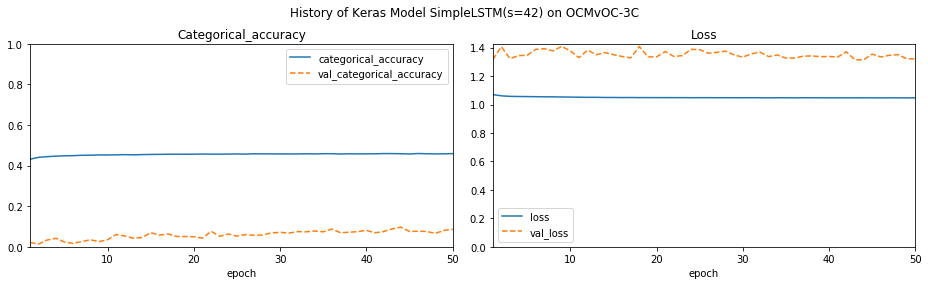

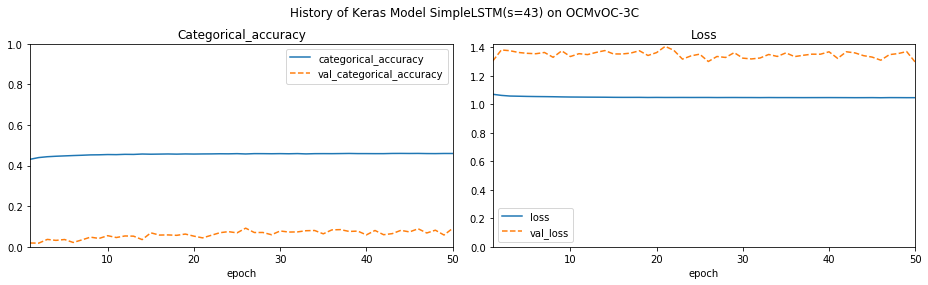

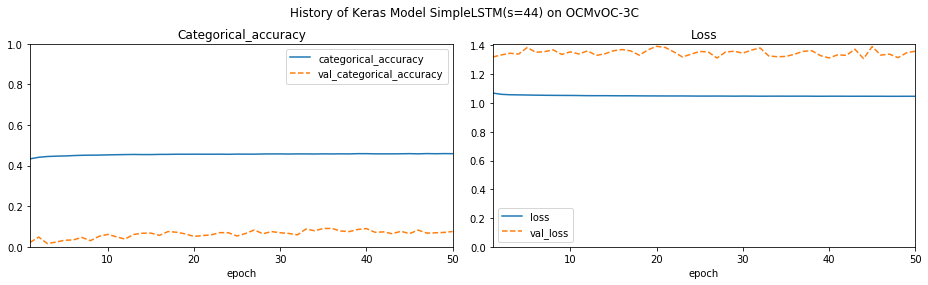

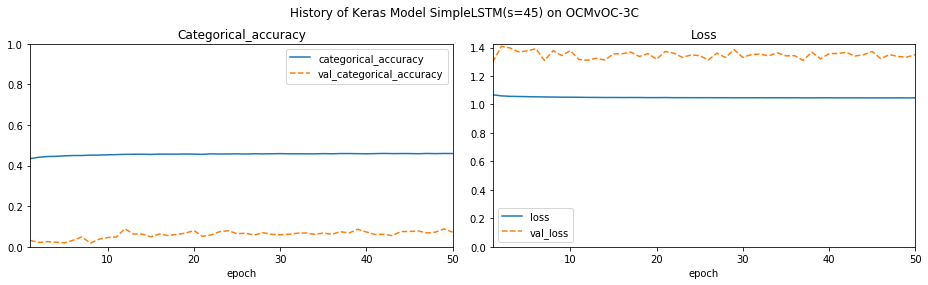

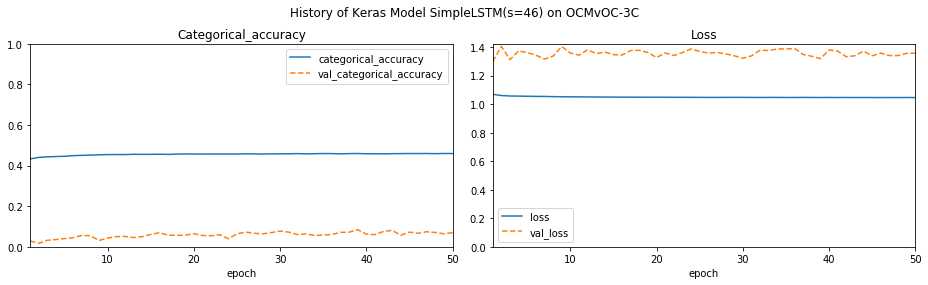

time: 8h 59min 1s


In [5]:
def get_predictors(n_features, n_timestamps=7, n_classes=3):
    seeds = range(42, 47)
    return [
        Heuristic('_l1', n_features, n_timestamps, Heuristic.last_movement, movement_feat=-3),
        Heuristic('_all', n_features, n_timestamps, Heuristic.mean_movement, movement_feat=-3),
        Heuristic('_l3', n_features, n_timestamps, Heuristic.last_three_movements, movement_feat=-3),
        Heuristic('_v_l1', n_features, n_timestamps, Heuristic.last_vix_movement, vix_feats=[-2, -1]),
        Heuristic('_a-1', n_features, n_timestamps, Heuristic.one_class, one_class=-1),
        Heuristic('_a0', n_features, n_timestamps, Heuristic.one_class, one_class=0),
        Heuristic('_a1', n_features, n_timestamps, Heuristic.one_class, one_class=1),
        *[SimpleLSTM(ignore_features=[-2, -1], n_timestamps=n_timestamps, n_features=n_features, n_classes=n_classes, seed=s) for s in seeds]
    ]
evaluator = Evaluator('baselines', datasets, get_predictors, '../reports', seed=42, store=True,
                      n_train_samples=300000, n_test_samples=60000, downsample=True)
metrics = evaluator()

In [6]:
evaluator.metrics

predictor,OCMvOC-3C Heu_a-1,OCMvOC-3C Heu_a0,OCMvOC-3C Heu_a1,OCMvOC-3C Heu_all,OCMvOC-3C Heu_l1,OCMvOC-3C Heu_l3,OCMvOC-3C Heu_v_l1,OCMvOC-3C SimpleLSTM
prec,0.0305,0.38732,0.04121,0.48596,0.49589,0.47801,0.47708,0.508264 +- 0.001780977259821139
rec,0.17465,0.62235,0.203,0.61192,0.49478,0.57255,0.53748,0.587024 +- 0.0043138011080716375
f1,0.05193,0.47748,0.06851,0.49151,0.49532,0.50233,0.49899,0.528154 +- 0.0018250150684309535
acc,0.17465,0.62235,0.203,0.61192,0.49478,0.57255,0.53748,0.587024 +- 0.0043138011080716375
mcc,0,0,0,0.03242,0.06792,0.03538,0.04411,0.099912 +- 0.0035430029635889356


time: 340 ms


In [ ]:
# evaluator._metrics.to_csv(os.path.join(evaluator.output_dir, f'custom/{evaluator.name}.csv'))
# evaluator.plot_histories()
# [comment]: <> (print_metrics_as_md "../reports/custom/ml-baselines-2.csv")
# print_metrics_as_md("../reports/custom/ml-baselines-2.csv")